In [1]:
# coding=utf-8
import time
import sys
import os
import datetime as dt
import warnings
warnings.filterwarnings("ignore")
sys.path.append("C:\\Users\\hushuntai\\svn\\python")

from IPython.display import display
import numpy as np
import pandas as pd
import statsmodels.api as sm
from matplotlib.pylab import mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['axes.unicode_minus'] = False
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import matplotlib.dates as mdate
from tqdm import tqdm_notebook

==========历史回测==========
1. 初始化
耗时 : 8.16
2. 循环计算


100% (96 of 96) |#########################| Elapsed Time: 0:01:07 Time: 0:01:07


耗时 : 67.48
3. 结果生成
耗时 : 0.94
总耗时 : 76.58



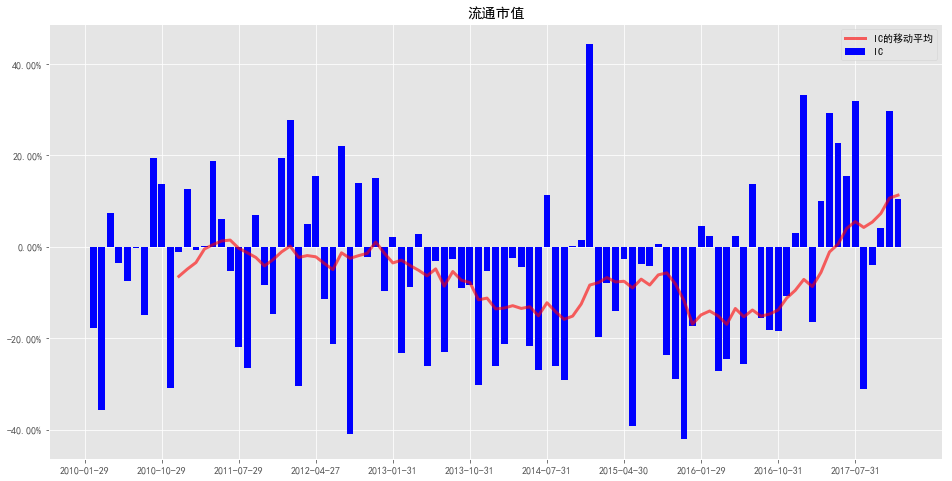
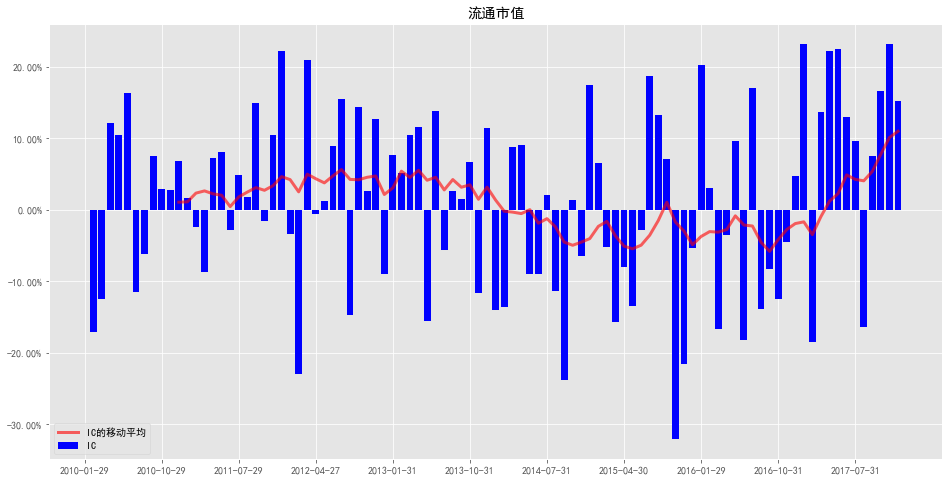
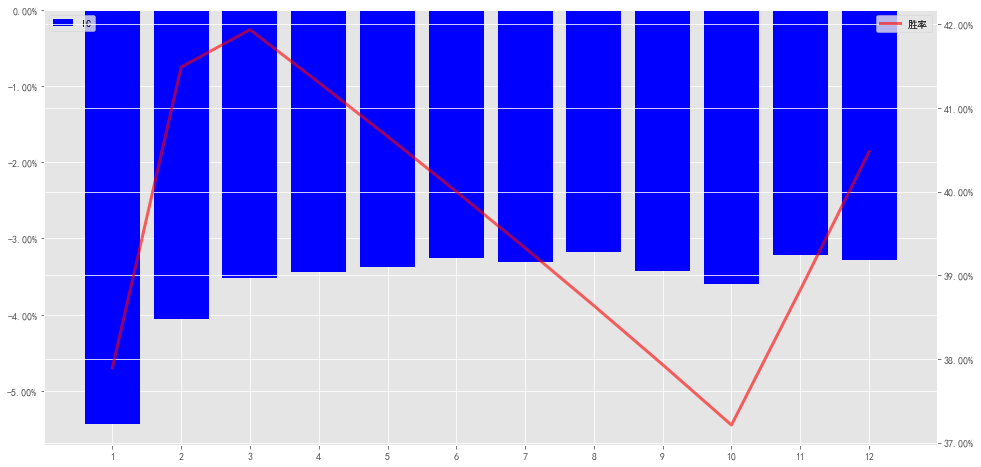
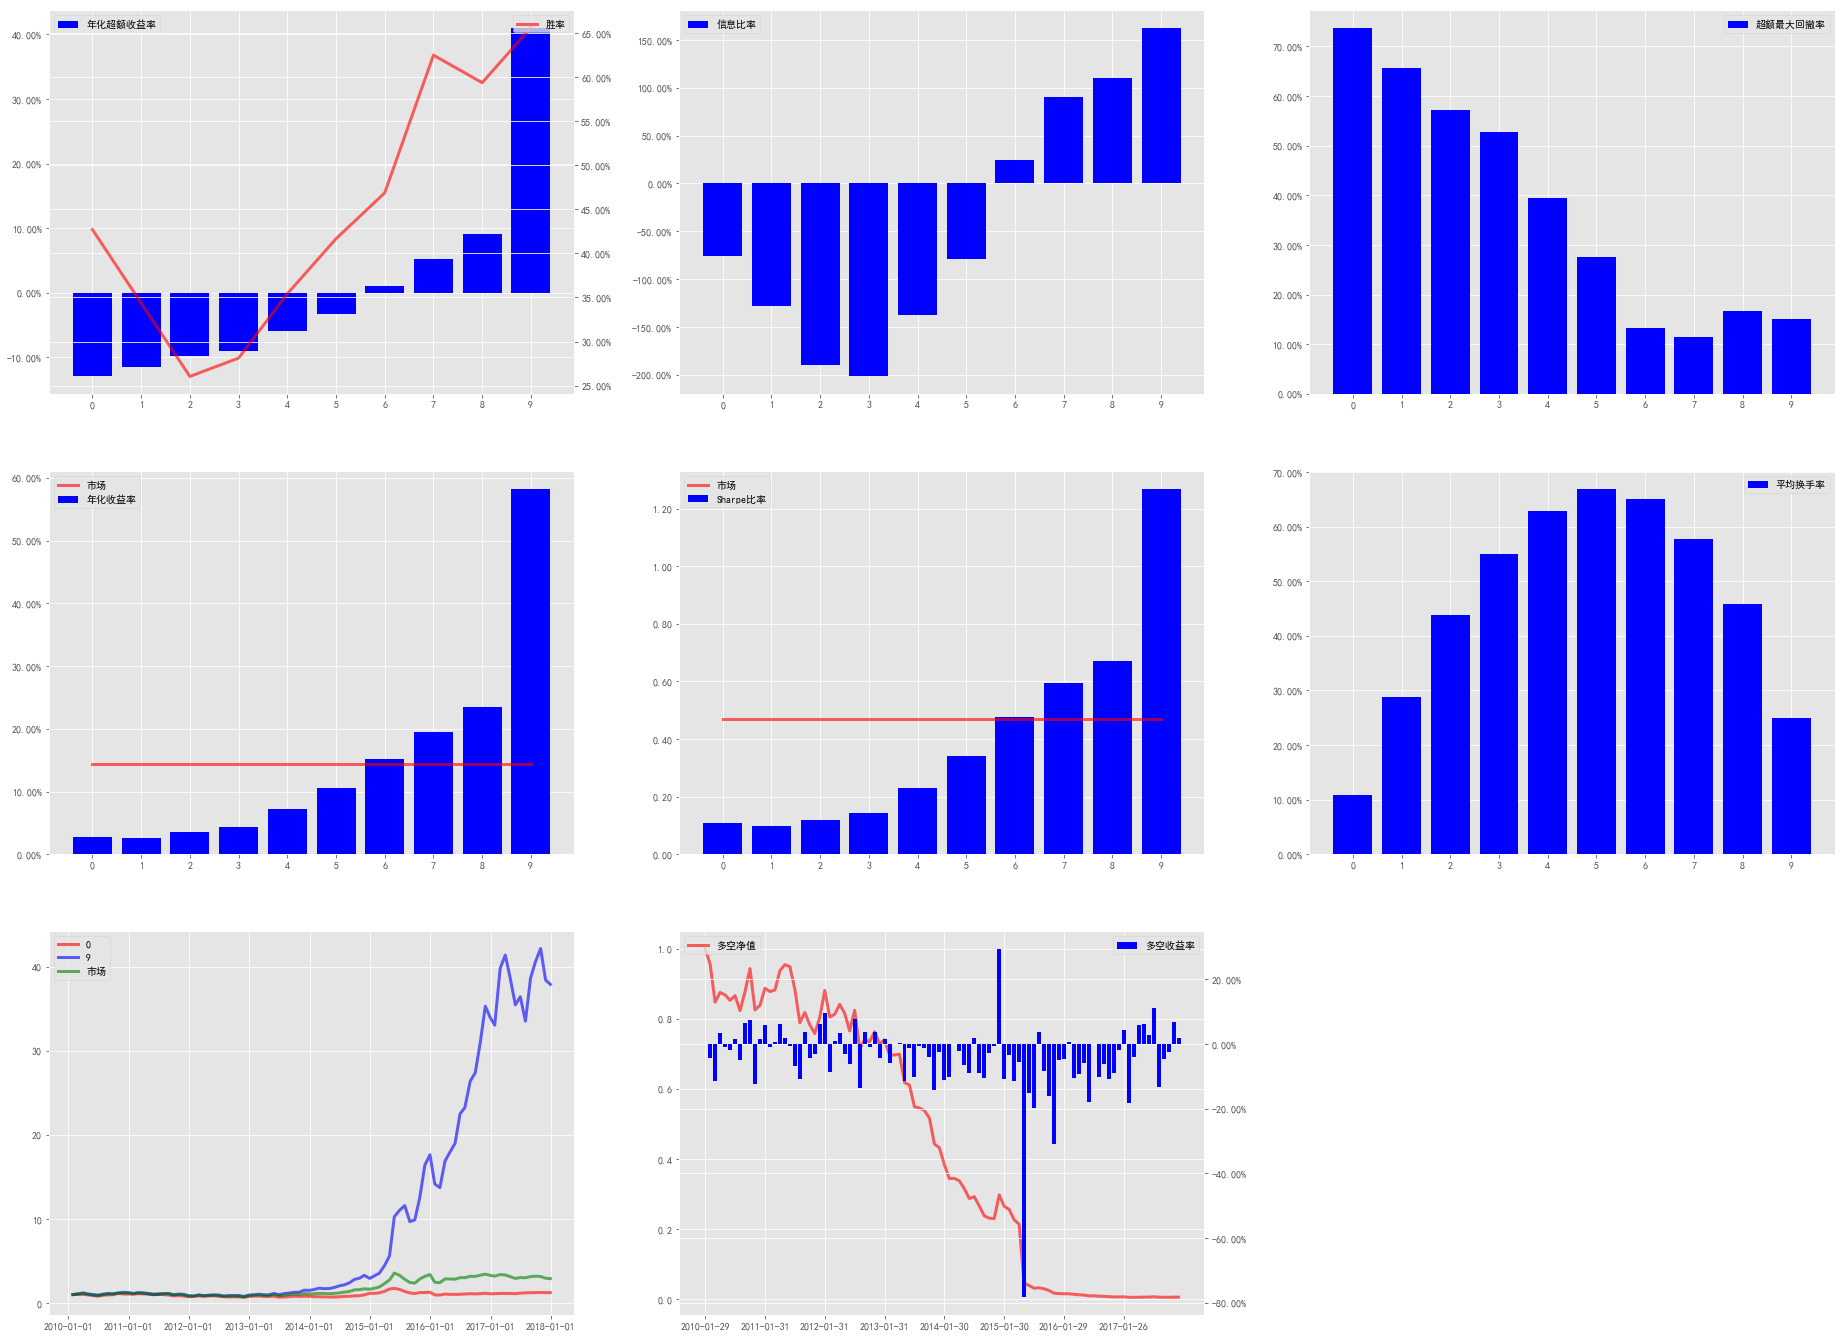
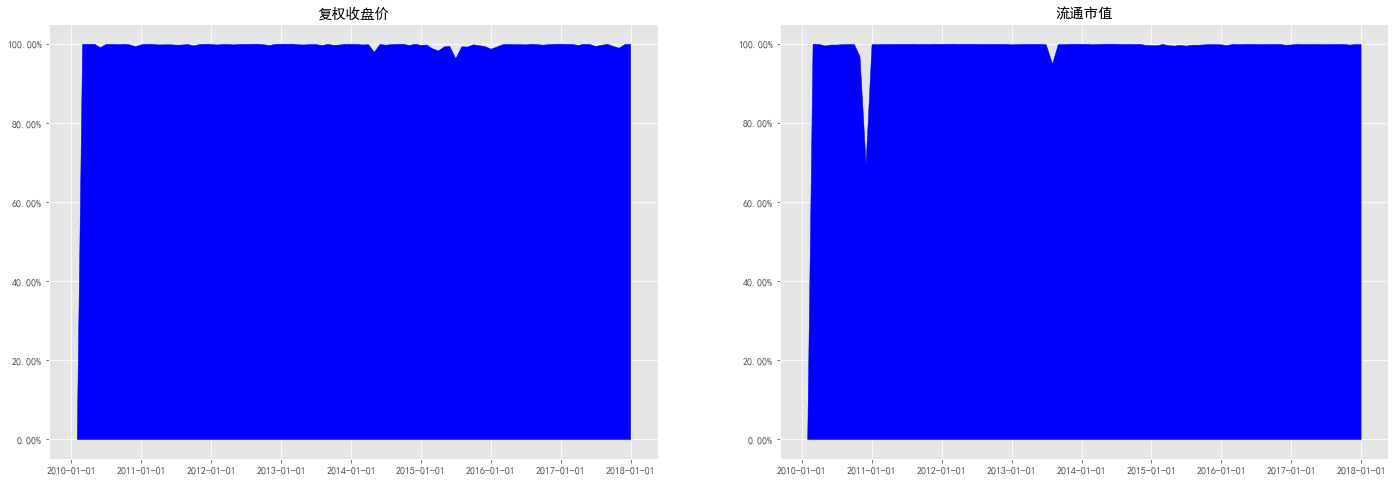
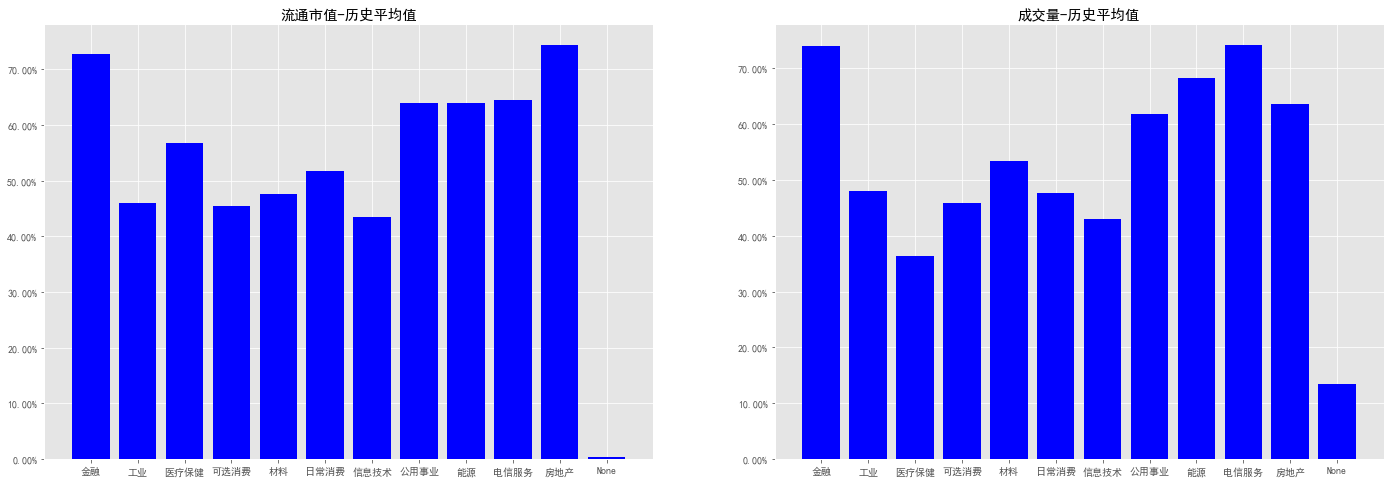
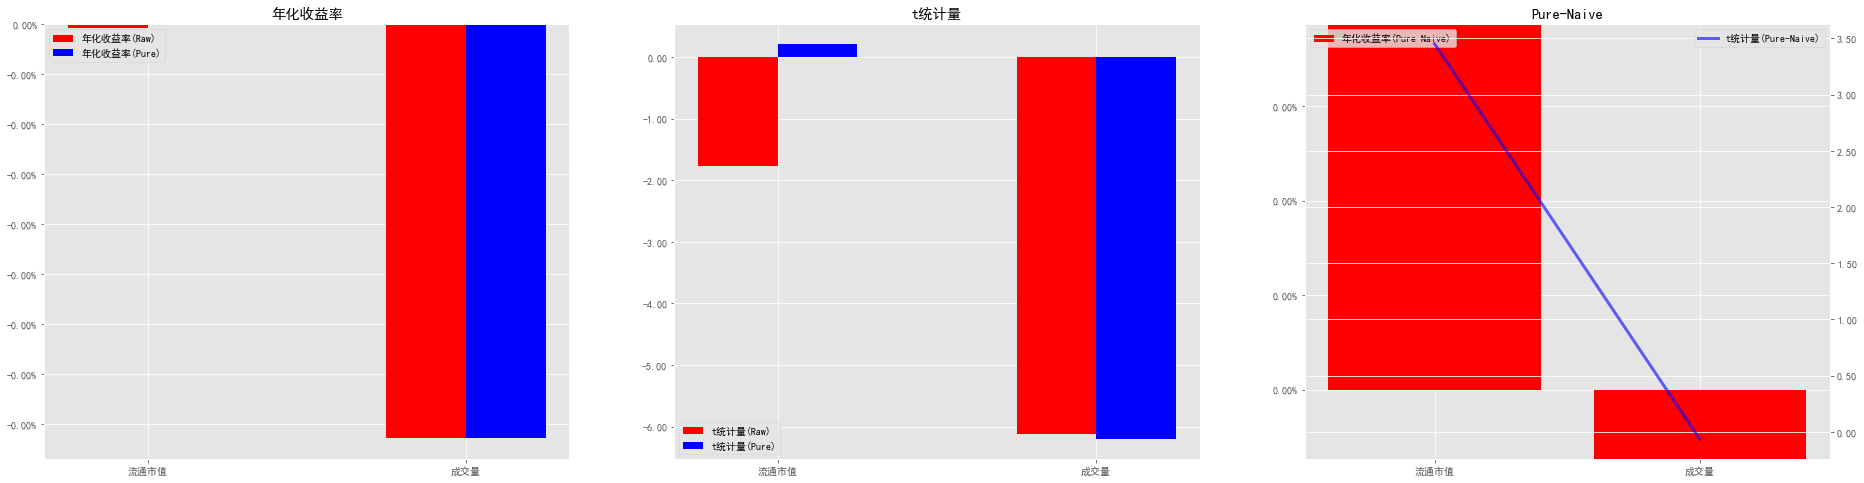

In [2]:
if __name__=='__main__':
    import matplotlib
    matplotlib.pyplot.ioff()
    import QuantStudio.api as QS
    
    # 创建因子库
    HDB = QS.FactorDB.HDF5DB()
    HDB.connect()
    
    # 创建自定义因子表
    MainFT = QS.FactorDB.CustomFT("MainFT")
    FT = HDB.getTable("ElementaryFactor")
    DTs = FT.getDateTime(ifactor_name="复权收盘价", start_dt=dt.datetime(2010, 1, 1), end_dt=dt.datetime(2017, 12, 31))
    MonthLastDTs = QS.Tools.DateTime.getMonthLastDateTime(DTs)
    MainFT.addFactors(factor_table=FT, factor_names=["复权收盘价", "流通市值", "成交量", "Wind行业"], args={})
    MainFT.setDateTime(MonthLastDTs)
    MainFT.setID(FT.getID(ifactor_name="复权收盘价"))
    
    # 创建回测模型
    Model = QS.BackTest.BackTestModel()
    # --------因子测试模块--------
    # IC 测试
    iModule = QS.BackTest.SectionFactor.IC(factor_table=MainFT)
    iModule["测试因子"] = ["流通市值"]
    iModule["价格因子"] = "复权收盘价"
    iModule["计算时点"] = MonthLastDTs
    Model.Modules.append(iModule)
    # 风险调整的 IC
    iModule = QS.BackTest.SectionFactor.RiskAdjustedIC(factor_table=MainFT)
    iModule["测试因子"] = ["流通市值"]
    iModule["价格因子"] = "复权收盘价"
    iModule["风险因子"] = ["成交量"]
    iModule["行业因子"] = "Wind行业"
    iModule["计算时点"] = MonthLastDTs
    Model.Modules.append(iModule)
    # IC 衰减
    iModule = QS.BackTest.SectionFactor.ICDecay(factor_table=MainFT)
    iModule["测试因子"] = "流通市值"
    iModule["价格因子"] = "复权收盘价"
    iModule["计算时点"] = MonthLastDTs
    Model.Modules.append(iModule)
    # 分位数组合测试
    iModule = QS.BackTest.SectionFactor.QuantilePortfolio(factor_table=MainFT)# IC 测试
    iModule["测试因子"] = "流通市值"
    iModule["价格因子"] = "复权收盘价"
    iModule["调仓时点"] = MonthLastDTs
    Model.Modules.append(iModule)
    # 因子换手率
    iModule = QS.BackTest.SectionFactor.FactorTurnover(factor_table=MainFT)
    iModule["测试因子"] = ["流通市值", "复权收盘价"]
    iModule["计算时点"] = MonthLastDTs
    Model.Modules.append(iModule)
    # 因子截面相关性
    iModule = QS.BackTest.SectionFactor.SectionCorrelation(factor_table=MainFT)
    iModule["测试因子"] = ["流通市值", "复权收盘价"]
    iModule["计算时点"] = MonthLastDTs
    iModule["相关性算法"] = ["spearman", "pearson"]
    Model.Modules.append(iModule)
    # 因子值的行业分布
    iModule = QS.BackTest.SectionFactor.IndustryDistribution(factor_table=MainFT)
    iModule["测试因子"] = ["流通市值", "成交量"]
    iModule["行业因子"] = "Wind行业"
    iModule["计算时点"] = MonthLastDTs
    Model.Modules.append(iModule)
    # Fama-MacBeth 回归
    iModule = QS.BackTest.SectionFactor.FamaMacBethRegression(factor_table=MainFT)
    iModule["测试因子"] = ["流通市值", "成交量"]
    iModule["价格因子"] = "复权收盘价"
    iModule["行业因子"] = "Wind行业"
    iModule["计算时点"] = MonthLastDTs
    Model.Modules.append(iModule)
    
    # 运行模型
    TestDateTimes = MainFT.getDateTime()
    Model.run(dts=TestDateTimes)
    
    display(Model)